<a href="https://colab.research.google.com/github/ada-nai/nptel-PMLTF/blob/master/Week%205/TF__Assignment_5_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Using Pretrained ConvNets

You will follow the general machine learning workflow.

1. Examine and understand the data
2. Build an input pipeline
3. Compose our model
  * Part-1: Load in our pretrained base model (and pretrained weights)
  * Part-2: Stack our classification layers on top
4. Train our model
5. Evaluate model


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


## Data preprocessing

### Data download

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),                                         
                                                            as_supervised=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


Show the first two images and labels from the training set:

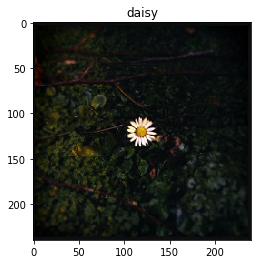

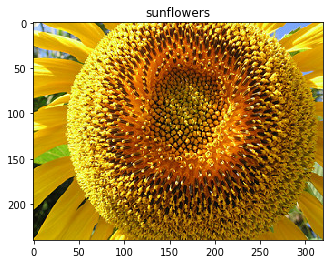

In [5]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Format the Data



In [0]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

Now shuffle and batch the data.

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


### Q5 What is the shape of one batch of data?

In [10]:
for image_batch, image_label in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# 1. Create the base model from the pre-trained convnets
You will create the base model from the **Inception V3** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This model has already learned the basic features that are common in 1000 objects that we see daily. Hence, it has a strong feature extraction capability. We download a network that doesn’t include the classification layers at the top, by specifying include_top=False argument, because we only want to use the feature extraction portion of these pre-trained convnets (convolutional base)

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model Inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87916544/87910968 [==============================] - 4s 0us/step


### Q6 What is the shape of a new block of features converted by the feature extractor?

In [0]:
feature_batch = base_model(image_batch)

In [13]:
feature_batch.shape

TensorShape([32, 3, 3, 2048])

## Feature extraction


### Freeze the convolutional base

In [0]:
# Write the code here to freeze convolutional base
base_model.trainable = False

In [15]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Add a classification head

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [0]:
# Write the code here to stack the all these layers

model = tf.keras.Sequential(
    [
     base_model,
     global_average_layer,
     prediction_layer
    ]
)

### Q7 What is the total number trainable TF variables in the model?

In [19]:
len(model.trainable_variables)

2

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Compile the model


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Q8 What is the total number of Trainable parameters in this model?

### Train the model

In [22]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
93/93 [==============================] - 27s 285ms/step - loss: 1.2054 - accuracy: 0.5207 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
93/93 [==============================] - 17s 183ms/step - loss: 0.8392 - accuracy: 0.7146 - val_loss: 1.9815 - val_accuracy: 0.5806
Epoch 3/10
93/93 [==============================] - 18s 193ms/step - loss: 0.7265 - accuracy: 0.7468 - val_loss: 1.9007 - val_accuracy: 0.6056
Epoch 4/10
93/93 [==============================] - 17s 184ms/step - loss: 0.6802 - accuracy: 0.7729 - val_loss: 2.1664 - val_accuracy: 0.5583
Epoch 5/10
93/93 [==============================] - 17s 184ms/step - loss: 0.6326 - accuracy: 0.7827 - val_loss: 2.1831 - val_accuracy: 0.6139
Epoch 6/10
93/93 [==============================] - 17s 187ms/step - loss: 0.6121 - accuracy: 0.7841 - val_loss: 2.2687 - val_accuracy: 0.6389
Epoch 7/10
93/93 [==============================] - 17s 183ms/step - loss: 0.5829 - accuracy: 0.7986 - val_loss: 1.6326 - val_accuracy

#<b>**model1** accuracy: 0.8075

### Learning curves


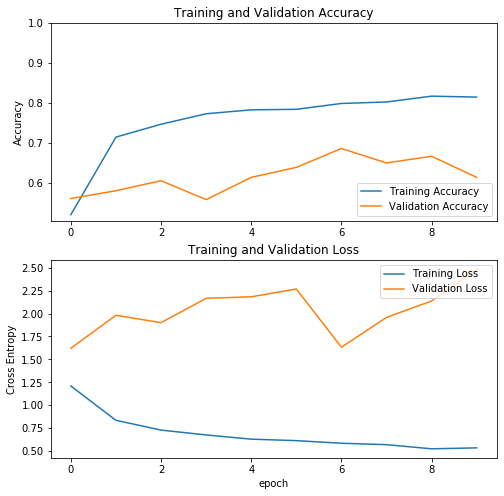

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 2. Fine tuning


### Un-freeze the top layers of the model


In [0]:
# Write code here for un-freezing the top layers
base_model.trainable = True

In [0]:
# Write the code for freezing layers before layer 250 in the model
limit = 250
for layer in base_model.layers[:limit]:
  layer.trainable = False

### Q9 What is the total number trainable TF variables in the model?

### Compile the model


In [0]:
model.compile(optimizer = 'adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
len(model.trainable_variables)

37

### Q10 What is the total numebr of Trainable parameters in this model now?

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,551,685
Non-trainable params: 11,261,344
_________________________________________________________________


## Trainable params: 10,551,685

### Continue Train the model

In [29]:
initial_epochs=10
total_epochs = initial_epochs + 10

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches)

Epoch 11/20
93/93 [==============================] - 29s 308ms/step - loss: 0.7197 - accuracy: 0.7753 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/20
93/93 [==============================] - 20s 213ms/step - loss: 0.2963 - accuracy: 0.9000 - val_loss: 1.1956 - val_accuracy: 0.8000
Epoch 13/20
93/93 [==============================] - 19s 209ms/step - loss: 0.1853 - accuracy: 0.9403 - val_loss: 1.2792 - val_accuracy: 0.7917
Epoch 14/20
93/93 [==============================] - 20s 210ms/step - loss: 0.1075 - accuracy: 0.9620 - val_loss: 2.9314 - val_accuracy: 0.6750
Epoch 15/20
93/93 [==============================] - 20s 212ms/step - loss: 0.1556 - accuracy: 0.9505 - val_loss: 1.8938 - val_accuracy: 0.7417
Epoch 16/20
93/93 [==============================] - 19s 209ms/step - loss: 0.1113 - accuracy: 0.9702 - val_loss: 2.5465 - val_accuracy: 0.6583
Epoch 17/20
93/93 [==============================] - 19s 209ms/step - loss: 0.0876 - accuracy: 0.9712 - val_loss: 3.8467 - val_a

## model2 accuracy: 0.9776

### Q11 Let the training accuracy in part-1 be x and training accuracy in part-2 be y (both after training is done). The value of | y-x | lies between?

In [30]:
x = 0.8075
y = 0.9776
abs(x-y)

0.17010000000000003

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

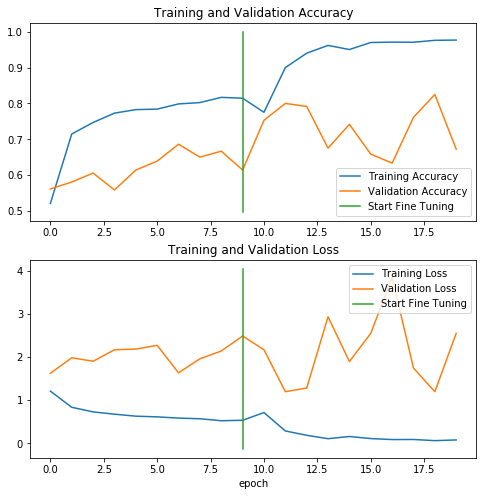

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()